In [1]:
# === Cell 1: Imports and Setup ===

from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import List, Tuple, Dict

# Import custom modules
from puzzle_utils import (
    PuzzlePiece, slice_into_grid, create_puzzle_pieces, 
    get_all_edge_strips, assemble_puzzle, get_complementary_edge
)
from edge_matching import (
    compute_edge_compatibility, build_compatibility_matrix, get_top_matches
)

# Paths
PROJECT_ROOT = Path(".")
DATASET_ROOT = PROJECT_ROOT / "Jigsaw Puzzle Dataset" / "Gravity Falls"
OUTPUT_ROOT = PROJECT_ROOT / "processed_images"
ENHANCED_DIR = OUTPUT_ROOT / "enhanced"
MASK_DIR = OUTPUT_ROOT / "masks"
CORRECT_DIR = DATASET_ROOT / "correct"

# Output for Phase 2
ASSEMBLED_DIR = OUTPUT_ROOT / "assembled"
ASSEMBLED_DIR.mkdir(exist_ok=True, parents=True)

print("✅ Setup complete!")
print(f"Enhanced images: {ENHANCED_DIR}")
print(f"Masks: {MASK_DIR}")
print(f"Ground truth: {CORRECT_DIR}")
print(f"Assembled output: {ASSEMBLED_DIR}")

✅ Setup complete!
Enhanced images: processed_images\enhanced
Masks: processed_images\masks
Ground truth: Jigsaw Puzzle Dataset\Gravity Falls\correct
Assembled output: processed_images\assembled


Loading puzzle: puzzle_2x2/0.jpg
Original: Jigsaw Puzzle Dataset\Gravity Falls\puzzle_2x2\0.jpg
Enhanced: processed_images\enhanced\puzzle_2x2_0.jpg
Mask: processed_images\masks\puzzle_2x2_0.jpg
Ground truth: Jigsaw Puzzle Dataset\Gravity Falls\correct\0.png


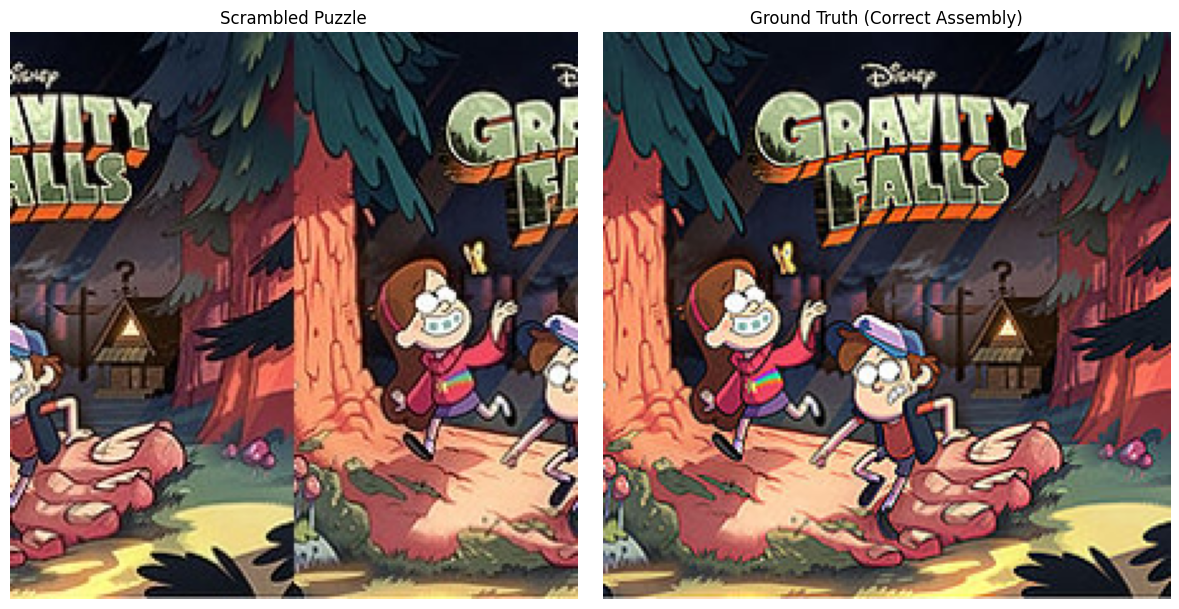

In [2]:
# === Cell 2: Load and Visualize a Sample Puzzle ===

# Choose a sample puzzle
puzzle_folder = "puzzle_2x2"
puzzle_id = 0
grid_size = 2

# Build file paths
original_path = DATASET_ROOT / puzzle_folder / f"{puzzle_id}.jpg"
enhanced_path = ENHANCED_DIR / f"{puzzle_folder}_{puzzle_id}.jpg"
mask_path = MASK_DIR / f"{puzzle_folder}_{puzzle_id}.jpg"
ground_truth_path = CORRECT_DIR / f"{puzzle_id}.png"

print(f"Loading puzzle: {puzzle_folder}/{puzzle_id}.jpg")
print(f"Original: {original_path}")
print(f"Enhanced: {enhanced_path}")
print(f"Mask: {mask_path}")
print(f"Ground truth: {ground_truth_path}")

# Load and display
scrambled = cv2.imread(str(original_path))
ground_truth = cv2.imread(str(ground_truth_path))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(scrambled, cv2.COLOR_BGR2RGB))
axes[0].set_title("Scrambled Puzzle")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB))
axes[1].set_title("Ground Truth (Correct Assembly)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

Slicing puzzle into 2x2 grid...
✅ Created 4 puzzle pieces


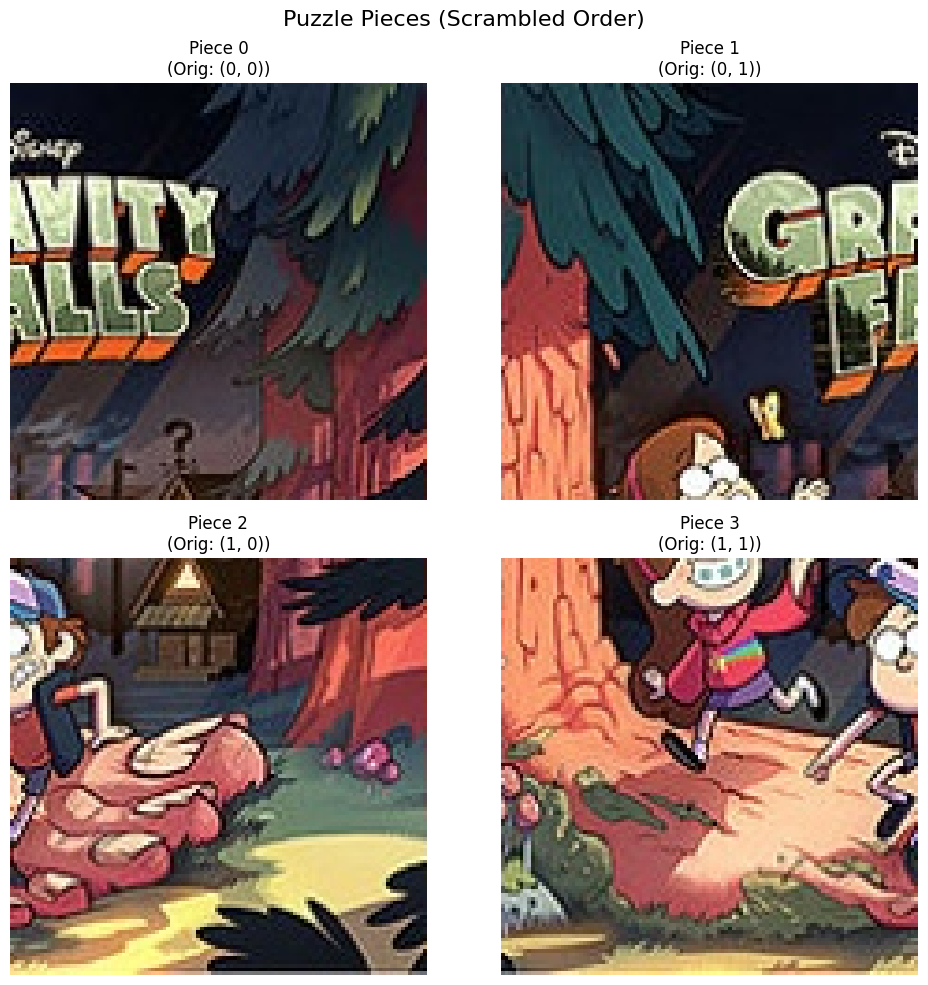

In [3]:
# === Cell 3: Create Puzzle Pieces ===

print(f"Slicing puzzle into {grid_size}x{grid_size} grid...")
pieces = create_puzzle_pieces(
    str(original_path),
    str(enhanced_path),
    str(mask_path),
    grid_size
)

print(f"✅ Created {len(pieces)} puzzle pieces")

# Visualize all pieces
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
if grid_size == 1:
    axes = np.array([[axes]])
elif grid_size == 2:
    axes = axes.reshape(2, 2)

for idx, piece in enumerate(pieces):
    row = idx // grid_size
    col = idx % grid_size
    axes[row, col].imshow(cv2.cvtColor(piece.original, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f"Piece {piece.piece_id}\n(Orig: {piece.original_pos})")
    axes[row, col].axis('off')

plt.suptitle(f"Puzzle Pieces (Scrambled Order)", fontsize=16)
plt.tight_layout()
plt.show()

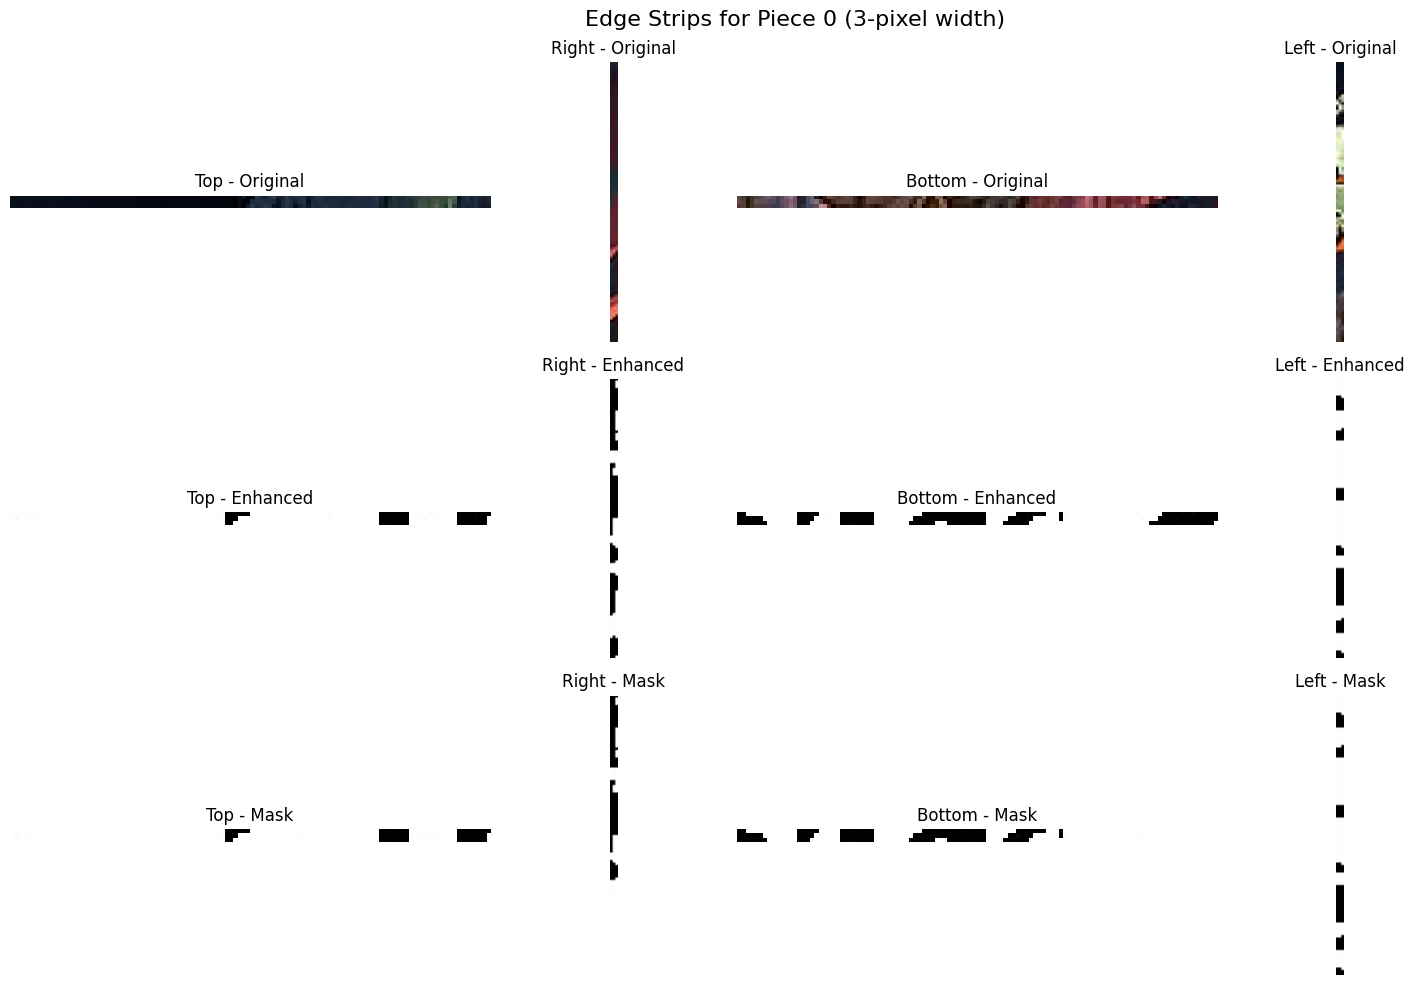

In [4]:
# === Cell 4: Visualize Edge Extraction ===

# Show edge strips for first piece
sample_piece = pieces[0]
edge_strips = get_all_edge_strips(sample_piece, strip_width=3)

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
edges = ['top', 'right', 'bottom', 'left']
sources = ['original', 'enhanced', 'mask']

for row, source in enumerate(sources):
    for col, edge in enumerate(edges):
        strip = edge_strips[edge][source]
        
        if source == 'original':
            axes[row, col].imshow(cv2.cvtColor(strip, cv2.COLOR_BGR2RGB))
        else:
            axes[row, col].imshow(strip, cmap='gray')
        
        axes[row, col].set_title(f"{edge.capitalize()} - {source.capitalize()}")
        axes[row, col].axis('off')

plt.suptitle(f"Edge Strips for Piece {sample_piece.piece_id} (3-pixel width)", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
# === Cell 5: Build Compatibility Matrix ===

print("Computing edge compatibility scores...")
start_time = time.time()

compatibility_matrix = build_compatibility_matrix(pieces, strip_width=3)

elapsed = time.time() - start_time
print(f"✅ Compatibility matrix computed in {elapsed:.2f} seconds")
print(f"Matrix shape: {compatibility_matrix.shape}")
print(f"Non-zero entries: {np.count_nonzero(compatibility_matrix)}")
print(f"Max score: {compatibility_matrix.max():.4f}")
print(f"Mean score: {compatibility_matrix[compatibility_matrix > 0].mean():.4f}")

Computing edge compatibility scores...
✅ Compatibility matrix computed in 0.01 seconds
Matrix shape: (4, 4, 4, 4)
Non-zero entries: 48
Max score: 0.8432
Mean score: 0.6203


Top 10 Edge Matches:
----------------------------------------------------------------------
1. Piece 1 (bottom) <-> Piece 3 (top): 0.8432
2. Piece 1 (right) <-> Piece 0 (left): 0.8198
3. Piece 0 (bottom) <-> Piece 2 (top): 0.8174
4. Piece 0 (left) <-> Piece 1 (right): 0.8167
5. Piece 3 (top) <-> Piece 1 (bottom): 0.7818
6. Piece 3 (right) <-> Piece 2 (left): 0.7773
7. Piece 2 (top) <-> Piece 0 (bottom): 0.7591
8. Piece 2 (left) <-> Piece 3 (right): 0.7412
9. Piece 1 (bottom) <-> Piece 2 (top): 0.7056
10. Piece 2 (top) <-> Piece 1 (bottom): 0.6892


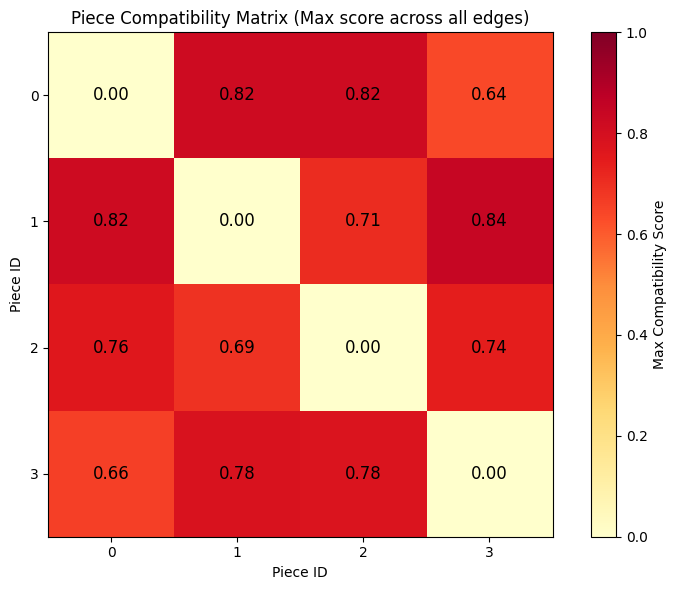

In [6]:
# === Cell 6: Visualize Top Matches ===

edge_names = ['top', 'right', 'bottom', 'left']
top_matches = get_top_matches(compatibility_matrix, k=10)

print("Top 10 Edge Matches:")
print("-" * 70)
for i, (p1_id, e1_idx, p2_id, e2_idx, score) in enumerate(top_matches, 1):
    print(f"{i}. Piece {p1_id} ({edge_names[e1_idx]}) <-> Piece {p2_id} ({edge_names[e2_idx]}): {score:.4f}")

# Visualize compatibility matrix as heatmap (simplified for 2x2)
if grid_size == 2:
    # Create a simplified visualization
    n_pieces = len(pieces)
    simple_matrix = np.zeros((n_pieces, n_pieces))
    
    for i in range(n_pieces):
        for j in range(n_pieces):
            if i != j:
                # Take max score across all edge pairs
                simple_matrix[i, j] = compatibility_matrix[i, :, j, :].max()
    
    plt.figure(figsize=(8, 6))
    plt.imshow(simple_matrix, cmap='YlOrRd', vmin=0, vmax=1)
    plt.colorbar(label='Max Compatibility Score')
    plt.title('Piece Compatibility Matrix (Max score across all edges)')
    plt.xlabel('Piece ID')
    plt.ylabel('Piece ID')
    plt.xticks(range(n_pieces))
    plt.yticks(range(n_pieces))
    
    # Add text annotations
    for i in range(n_pieces):
        for j in range(n_pieces):
            text = plt.text(j, i, f"{simple_matrix[i, j]:.2f}",
                          ha="center", va="center", color="black", fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [7]:
# === Cell 7: Greedy Assembly Algorithm ===

def greedy_assemble(pieces: List[PuzzlePiece], compatibility_matrix: np.ndarray, 
                    grid_size: int) -> np.ndarray:
    """
    Greedily assemble puzzle by placing pieces with highest compatibility.
    
    Args:
        pieces: List of puzzle pieces
        compatibility_matrix: Edge compatibility scores
        grid_size: Size of the grid (2, 4, or 8)
        
    Returns:
        2D array of piece IDs showing the arrangement
    """
    n_pieces = len(pieces)
    arrangement = np.full((grid_size, grid_size), -1, dtype=int)
    placed = set()
    edge_names = ['top', 'right', 'bottom', 'left']
    
    # Get all matches sorted by score
    all_matches = get_top_matches(compatibility_matrix, k=n_pieces * n_pieces * 16)
    
    # Place first piece in top-left corner
    first_piece_id = 0
    arrangement[0, 0] = first_piece_id
    placed.add(first_piece_id)
    print(f"Placed piece {first_piece_id} at position (0, 0)")
    
    # Greedily place remaining pieces
    while len(placed) < n_pieces:
        best_score = -1
        best_placement = None
        
        # Try to find best next placement
        for row in range(grid_size):
            for col in range(grid_size):
                if arrangement[row, col] != -1:
                    continue  # Already filled
                
                # Check if this position has a placed neighbor
                neighbors = []
                if row > 0 and arrangement[row-1, col] != -1:
                    neighbors.append((arrangement[row-1, col], 'top'))
                if col > 0 and arrangement[row, col-1] != -1:
                    neighbors.append((arrangement[row, col-1], 'left'))
                if row < grid_size-1 and arrangement[row+1, col] != -1:
                    neighbors.append((arrangement[row+1, col], 'bottom'))
                if col < grid_size-1 and arrangement[row, col+1] != -1:
                    neighbors.append((arrangement[row, col+1], 'right'))
                
                if not neighbors:
                    continue  # No placed neighbors
                
                # Try each unplaced piece
                for piece_id in range(n_pieces):
                    if piece_id in placed:
                        continue
                    
                    # Compute total score with all neighbors
                    total_score = 0
                    valid = True
                    
                    for neighbor_id, neighbor_edge in neighbors:
                        my_edge = get_complementary_edge(neighbor_edge)
                        my_edge_idx = edge_names.index(my_edge)
                        neighbor_edge_idx = edge_names.index(neighbor_edge)
                        
                        score = compatibility_matrix[piece_id, my_edge_idx, neighbor_id, neighbor_edge_idx]
                        total_score += score
                    
                    avg_score = total_score / len(neighbors)
                    
                    if avg_score > best_score:
                        best_score = avg_score
                        best_placement = (piece_id, row, col)
        
        if best_placement is None:
            # No valid placement found, place remaining pieces randomly
            for row in range(grid_size):
                for col in range(grid_size):
                    if arrangement[row, col] == -1:
                        for piece_id in range(n_pieces):
                            if piece_id not in placed:
                                arrangement[row, col] = piece_id
                                placed.add(piece_id)
                                print(f"Randomly placed piece {piece_id} at ({row}, {col})")
                                break
                        break
        else:
            piece_id, row, col = best_placement
            arrangement[row, col] = piece_id
            placed.add(piece_id)
            print(f"Placed piece {piece_id} at position ({row}, {col}) with score {best_score:.4f}")
    
    return arrangement

print("Starting greedy assembly...")
start_time = time.time()

arrangement = greedy_assemble(pieces, compatibility_matrix, grid_size)

elapsed = time.time() - start_time
print(f"\n✅ Assembly complete in {elapsed:.2f} seconds")
print(f"\nFinal arrangement:\n{arrangement}")

Starting greedy assembly...
Placed piece 0 at position (0, 0)
Placed piece 1 at position (0, 1) with score 0.8198
Placed piece 2 at position (1, 0) with score 0.5390
Placed piece 3 at position (1, 1) with score 0.6044

✅ Assembly complete in 0.00 seconds

Final arrangement:
[[0 1]
 [2 3]]


Saved assembled image to: processed_images\assembled\puzzle_2x2_0_assembled.jpg


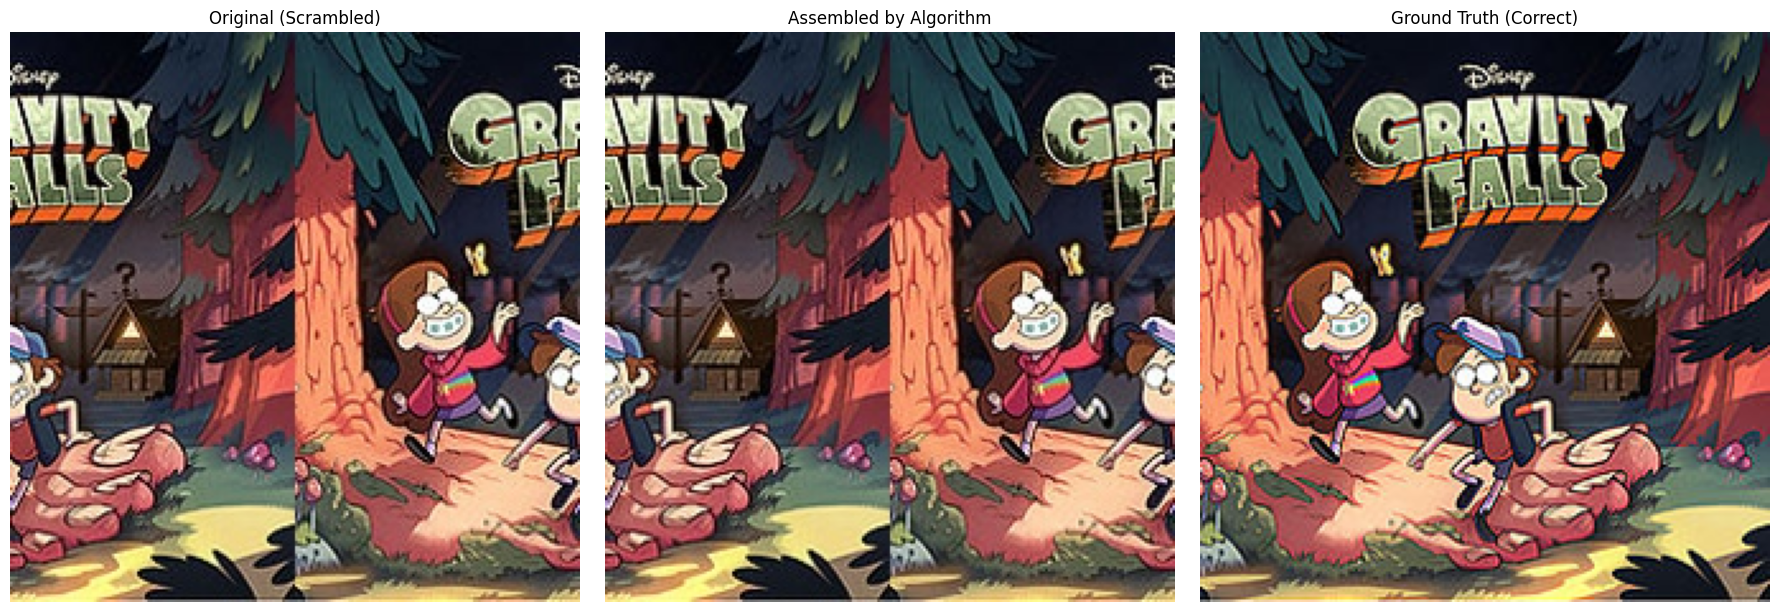

In [8]:
# === Cell 8: Assemble and Visualize Result ===

assembled_image = assemble_puzzle(pieces, arrangement, grid_size)

# Save assembled image
output_path = ASSEMBLED_DIR / f"{puzzle_folder}_{puzzle_id}_assembled.jpg"
cv2.imwrite(str(output_path), assembled_image)
print(f"Saved assembled image to: {output_path}")

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(cv2.cvtColor(scrambled, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original (Scrambled)")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(assembled_image, cv2.COLOR_BGR2RGB))
axes[1].set_title("Assembled by Algorithm")
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB))
axes[2].set_title("Ground Truth (Correct)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# === Cell 9: Compute Accuracy Metrics ===

from skimage.metrics import structural_similarity as ssim

def compute_accuracy(assembled: np.ndarray, ground_truth: np.ndarray) -> Dict[str, float]:
    """
    Compute accuracy metrics between assembled and ground truth images.
    """
    # Ensure same size
    if assembled.shape != ground_truth.shape:
        ground_truth = cv2.resize(ground_truth, (assembled.shape[1], assembled.shape[0]))
    
    # Convert to grayscale for SSIM
    assembled_gray = cv2.cvtColor(assembled, cv2.COLOR_BGR2GRAY)
    gt_gray = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY)
    
    # SSIM
    ssim_score = ssim(assembled_gray, gt_gray)
    
    # MSE
    mse = np.mean((assembled.astype(float) - ground_truth.astype(float)) ** 2)
    
    # PSNR
    if mse > 0:
        psnr = 10 * np.log10(255**2 / mse)
    else:
        psnr = float('inf')
    
    return {
        'ssim': ssim_score,
        'mse': mse,
        'psnr': psnr
    }

def compute_piece_accuracy(arrangement: np.ndarray, pieces: List[PuzzlePiece]) -> float:
    """
    Compute percentage of correctly placed pieces.
    """
    grid_size = arrangement.shape[0]
    correct = 0
    
    for row in range(grid_size):
        for col in range(grid_size):
            piece_id = arrangement[row, col]
            piece = pieces[piece_id]
            
            if piece.original_pos == (row, col):
                correct += 1
    
    return 100.0 * correct / len(pieces)

# Compute metrics
image_metrics = compute_accuracy(assembled_image, ground_truth)
piece_accuracy = compute_piece_accuracy(arrangement, pieces)

print("=" * 50)
print("ACCURACY METRICS")
print("=" * 50)
print(f"Structural Similarity (SSIM): {image_metrics['ssim']:.4f}")
print(f"Mean Squared Error (MSE): {image_metrics['mse']:.2f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {image_metrics['psnr']:.2f} dB")
print(f"Piece Placement Accuracy: {piece_accuracy:.1f}%")
print("=" * 50)

ACCURACY METRICS
Structural Similarity (SSIM): 0.0563
Mean Squared Error (MSE): 7642.79
Peak Signal-to-Noise Ratio (PSNR): 9.30 dB
Piece Placement Accuracy: 100.0%


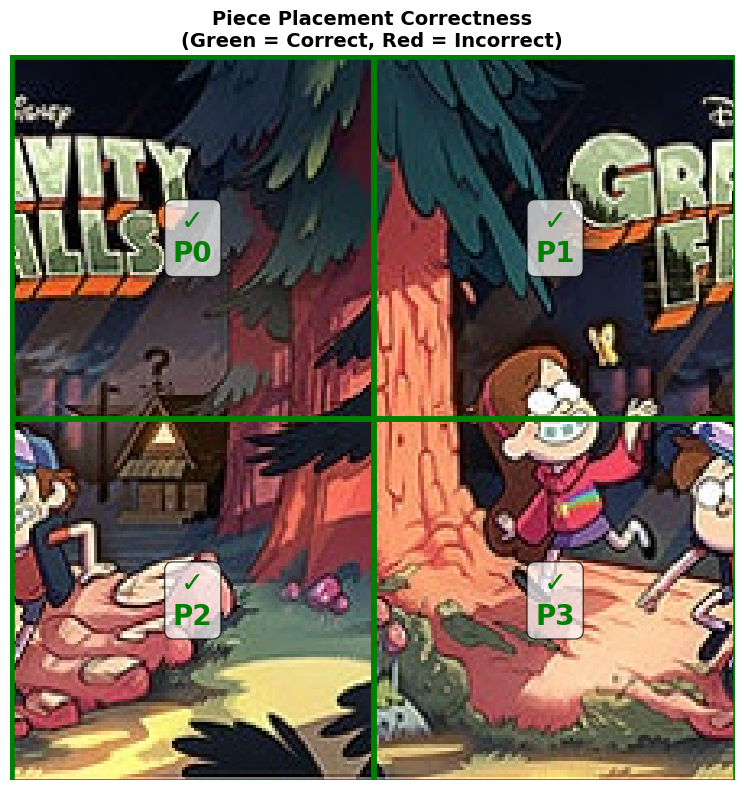


Correctly placed pieces: 4/4


In [10]:
# === Cell 10: Visualize Piece Placement Correctness ===

# Create visualization showing correct vs incorrect placements
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Draw assembled image
ax.imshow(cv2.cvtColor(assembled_image, cv2.COLOR_BGR2RGB))

# Overlay grid and mark correct/incorrect pieces
tile_h = assembled_image.shape[0] // grid_size
tile_w = assembled_image.shape[1] // grid_size

for row in range(grid_size):
    for col in range(grid_size):
        piece_id = arrangement[row, col]
        piece = pieces[piece_id]
        
        # Check if correctly placed
        is_correct = (piece.original_pos == (row, col))
        
        # Draw rectangle
        x = col * tile_w
        y = row * tile_h
        
        color = 'green' if is_correct else 'red'
        linewidth = 4
        
        rect = plt.Rectangle((x, y), tile_w, tile_h, 
                            fill=False, edgecolor=color, linewidth=linewidth)
        ax.add_patch(rect)
        
        # Add text
        status = "✓" if is_correct else "✗"
        ax.text(x + tile_w//2, y + tile_h//2, 
               f"{status}\nP{piece_id}",
               color=color, fontsize=20, fontweight='bold',
               ha='center', va='center',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.set_title(f"Piece Placement Correctness\n(Green = Correct, Red = Incorrect)", 
            fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nCorrectly placed pieces: {int(piece_accuracy * len(pieces) / 100)}/{len(pieces)}")